## assemble predictions and historical data

In [2]:
import pandas as pd

import os
import pickle

import re

import copy

from datetime import date, datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib notebook

In [3]:
def tack_on_year(date):
    """Remove leading zeros in month, and add year to date. 
    This is a bit hacky since years were not stored with daily weather forecasts."""
     
    if date.split('-')[0]=='12':
        return date + '-2018'
    elif date.split('-')[0]=='1':
        return date + '-2019'
    elif date.split('-')[0]=='01':
        return date[1:] + '-2019'
    elif date.split('-')[0]=='2':
        return date + '-2019'
    elif date.split('-')[0]=='02':
        return date[1:] + '-2019'    
    else:
        #print(date)
        return 'Error on date'
    
def difference_in_dates(day_of_forecast, forecast_for_day):
    """Format the dates, and then find the difference. The formats for the 'forecast_for_day' are not universally formatted.
    Returns: days before day of interest that forecast is made type int"""
    
    dof_month, dof_day, dof_year = [int(i) for i in day_of_forecast.split('-')]
    dof_datetime = date(dof_year, dof_month, dof_day)
       
    ffd_month, ffd_day = forecast_for_day.split('-')
    
    ffd_day = int(ffd_day)
    
    #strip off leading zeros
    if ffd_month[0]=='0':
        ffd_month = int(ffd_month[1:])
    else:
        ffd_month = int(ffd_month)
          
    if ffd_month == 12:
        ffd_year = 2018
    elif ffd_month ==1:
        ffd_year = 2019
    else:
        return 'Error on month'
     
    ffd_datetime = date(ffd_year, ffd_month, ffd_day)
    
    delta = ffd_datetime - dof_datetime
    return delta.days

In [4]:
def strip_leading_zeros(date):
    """Unforunately a lot of the original files are stored without leading zeros, so I will jsut switch to that standard for now. """
    date = datetime.strptime(date,'%m-%d-%Y')
    date = date.strftime('%-m-%-d-%Y')
    return date

In [5]:
# import csvs and format

awc_historical_df_03766 = pd.read_csv('historical_weather_data/Leb_awc_historical_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
awc_historical_df_03766.index = awc_historical_df_03766.index.map(strip_leading_zeros)

awc_historical_df_12590 = pd.read_csv('historical_weather_data/Wapp_awc_historical_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
awc_historical_df_12590.index = awc_historical_df_12590.index.map(strip_leading_zeros)

awc_historical_df_44124 = pd.read_csv('historical_weather_data/Lyn_awc_historical_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
awc_historical_df_44124.index = awc_historical_df_44124.index.map(strip_leading_zeros)

wdc_historical_df_03766 = pd.read_csv('historical_weather_data/Leb_wdc_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
wdc_historical_df_03766.index = wdc_historical_df_03766.index.map(strip_leading_zeros)

wdc_historical_df_12590 = pd.read_csv('historical_weather_data/Wapp_wdc_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
wdc_historical_df_12590.index = wdc_historical_df_12590.index.map(strip_leading_zeros)

wdc_historical_df_44124 = pd.read_csv('historical_weather_data/Lyn_wdc_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
wdc_historical_df_44124.index = wdc_historical_df_44124.index.map(strip_leading_zeros)

wug_historical_df_03766 = pd.read_csv('historical_weather_data/Leb_wug_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
wug_historical_df_03766.index = wug_historical_df_03766.index.map(strip_leading_zeros)

wug_historical_df_12590 = pd.read_csv('historical_weather_data/Wapp_wug_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
wug_historical_df_12590.index = wug_historical_df_12590.index.map(strip_leading_zeros)

wug_historical_df_44124 = pd.read_csv('historical_weather_data/Lyn_wug_weather_data.csv', 
                                      header = [0,1],
                                      index_col = 0,
                                     )
wug_historical_df_44124.index = wug_historical_df_44124.index.map(strip_leading_zeros)

In [6]:
# populate a list of formatted dates of forecasts. 

forecasts_saved_on_days = os.listdir( 'daily_forecasts/')
forecasts_saved_on_days.remove('.DS_Store')

#format days on which forecasts were saved
for i,f in enumerate(forecasts_saved_on_days):
    f = f.split('_')[3:]
    f = ''.join(f)
    forecasts_saved_on_days[i] = f

In [7]:
# populate a list of formatted dates forecasted for. 

test_name = '03766'

days_forecasted_for = []

for f in forecasts_saved_on_days:

    with open('daily_forecasts/' + 'Saved_on_DAY_' + str(f) +  '/' + test_name + '_forecast.pkl','rb') as f:

        forecasts = pickle.load(f)
        
        for site in forecasts.keys():
            
            days_forecasted_for = days_forecasted_for + list(forecasts[site].keys())

#get rid of leading 0 issues and add year
days_forecasted_for = [tack_on_year(f) for f in days_forecasted_for]
#get rid of dups
days_forecasted_for = list(set(days_forecasted_for))
# sort as datetimes
temp_dates = [datetime.strptime(d, '%m-%d-%Y') for d in days_forecasted_for]
temp_dates.sort()
days_forecasted_for = [datetime.strftime(d, '%-m-%-d-%Y') for d in temp_dates]

In [8]:
def get_low_high_temp_forecasts(day_of_forecast, place_zip, dicts_to_update):
    
    awc_dict, wdc_dict, wug_dict = dicts_to_update
      
    forecast_folder = 'Saved_on_DAY_' + day_of_forecast + '/'
    file_name = place + '_' + 'forecast.pkl'  

    try:
        with open('daily_forecasts/' + forecast_folder + file_name, 'rb') as f:

            forecasts = pickle.load(f)

            #awc high and low temp
                    
            awc_forecast_on_days = forecasts['awc_forecast'].keys()
        
            for d in awc_forecast_on_days:
            
                
                days_prior_forecasting = difference_in_dates(day_of_forecast = day_of_forecast, forecast_for_day = d)
                days_prior_forecasting = days_prior_forecasting
                          
                awc_high = forecasts['awc_forecast'][d]['hi_temp_day']
                awc_high = int(re.findall('\d+', awc_high)[0])                
                         
                awc_low = forecasts['awc_forecast'][d]['low_temp_night']
                awc_low = int(re.findall('\d+', awc_low)[0])
  
                d = tack_on_year(d)
                awc_dict[d]['high']['pred'][days_prior_forecasting] = awc_high
                awc_dict[d]['low']['pred'][days_prior_forecasting] = awc_low                         
            

            wdc_forecast_on_days = forecasts['wdc_forecast'].keys()
            
            for d in wdc_forecast_on_days:
                
                days_prior_forecasting = difference_in_dates(day_of_forecast = day_of_forecast, forecast_for_day = d)
                days_prior_forecasting = days_prior_forecasting
                          
                wdc_high = forecasts['wdc_forecast'][d]['day']['temperature']
                              
                wdc_low = forecasts['wdc_forecast'][d]['night']['temperature']

                d = tack_on_year(d)
                wdc_dict[d]['high']['pred'][days_prior_forecasting] = wdc_high
                wdc_dict[d]['low']['pred'][days_prior_forecasting] = wdc_low  
                
                
            wug_forecast_on_days = forecasts['wug_forecast'].keys()
            
            for d in wug_forecast_on_days:
                
                days_prior_forecasting = difference_in_dates(day_of_forecast = day_of_forecast, forecast_for_day = d)
                days_prior_forecasting = days_prior_forecasting
                          
                wug_high = forecasts['wug_forecast'][d]['high_temp']           
                         
                wug_low = forecasts['wug_forecast'][d]['low_temp']
  
                d = tack_on_year(d)
                wug_dict[d]['high']['pred'][days_prior_forecasting] = wug_high
                wug_dict[d]['low']['pred'][days_prior_forecasting] = wug_low  
            

    except FileNotFoundError:
        print('No forecast made on that day.')
        

In [9]:
#get the forecasts

blank_dict = {'high':{'actual':'', 'pred':{}},
              'low': {'actual':'', 'pred':{}},         
              }

awc_12590_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}
wdc_12590_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}
wug_12590_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}

place = '12590'
for day in forecasts_saved_on_days:
    get_low_high_temp_forecasts(day_of_forecast = day, place_zip = place, dicts_to_update = (awc_12590_dict, wdc_12590_dict, wug_12590_dict) )
    
    
awc_03766_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}
wdc_03766_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}
wug_03766_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}

place = '03766'
for day in forecasts_saved_on_days:
    get_low_high_temp_forecasts(day_of_forecast = day, place_zip = place, dicts_to_update = (awc_03766_dict, wdc_03766_dict, wug_03766_dict) )    
    
    
awc_44124_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}
wdc_44124_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}
wug_44124_dict = {d:copy.deepcopy(blank_dict) for d in days_forecasted_for}

place = '44124'
for day in forecasts_saved_on_days:
    get_low_high_temp_forecasts(day_of_forecast = day, place_zip = place, dicts_to_update = (awc_44124_dict, wdc_44124_dict, wug_44124_dict) )    

No forecast made on that day.
No forecast made on that day.


In [10]:
# sort each entry by the days before day forecasting for

for d in awc_12590_dict.keys():
    for hL in awc_12590_dict[d].keys():
        sorted_keys = sorted(awc_12590_dict[d][hL]['pred'].keys(), key = lambda x: x)
        awc_12590_dict[d][hL]['pred'] = {k:awc_12590_dict[d][hL]['pred'][k] for k in sorted_keys}
        
for d in awc_03766_dict.keys():
    for hL in awc_03766_dict[d].keys():
        sorted_keys = sorted(awc_03766_dict[d][hL]['pred'].keys(), key = lambda x: x)
        awc_03766_dict[d][hL]['pred'] = {k:awc_03766_dict[d][hL]['pred'][k] for k in sorted_keys}
        
for d in awc_44124_dict.keys():
    for hL in awc_44124_dict[d].keys():
        sorted_keys = sorted(awc_44124_dict[d][hL]['pred'].keys(), key = lambda x: x)
        awc_44124_dict[d][hL]['pred'] = {k:awc_44124_dict[d][hL]['pred'][k] for k in sorted_keys}
        
        
for d in wdc_12590_dict.keys():
    for hL in wdc_12590_dict[d].keys():
        sorted_keys = sorted(wdc_12590_dict[d][hL]['pred'].keys(), key = lambda x: x)
        wdc_12590_dict[d][hL]['pred'] = {k:wdc_12590_dict[d][hL]['pred'][k] for k in sorted_keys}
        
for d in wdc_03766_dict.keys():
    for hL in wdc_03766_dict[d].keys():
        sorted_keys = sorted(wdc_03766_dict[d][hL]['pred'].keys(), key = lambda x: x)
        wdc_03766_dict[d][hL]['pred'] = {k:wdc_03766_dict[d][hL]['pred'][k] for k in sorted_keys}
        
for d in wdc_44124_dict.keys():
    for hL in wdc_44124_dict[d].keys():
        sorted_keys = sorted(wdc_44124_dict[d][hL]['pred'].keys(), key = lambda x: x)
        wdc_44124_dict[d][hL]['pred'] = {k:wdc_44124_dict[d][hL]['pred'][k] for k in sorted_keys}
      
    
    
for d in wug_12590_dict.keys():
    for hL in wug_12590_dict[d].keys():
        sorted_keys = sorted(wug_12590_dict[d][hL]['pred'].keys(), key = lambda x: x)
        wug_12590_dict[d][hL]['pred'] = {k:wug_12590_dict[d][hL]['pred'][k] for k in sorted_keys}
        
for d in wug_03766_dict.keys():
    for hL in wug_03766_dict[d].keys():
        sorted_keys = sorted(wug_03766_dict[d][hL]['pred'].keys(), key = lambda x: x)
        wug_03766_dict[d][hL]['pred'] = {k:wug_03766_dict[d][hL]['pred'][k] for k in sorted_keys}
        
for d in wug_44124_dict.keys():
    for hL in wug_44124_dict[d].keys():
        sorted_keys = sorted(wug_44124_dict[d][hL]['pred'].keys(), key = lambda x: x)
        wug_44124_dict[d][hL]['pred'] = {k:wug_44124_dict[d][hL]['pred'][k] for k in sorted_keys}

In [11]:
# get the historical data
for d in awc_12590_dict.keys():
    awc_12590_dict[d]['high']['actual'] = awc_historical_df_12590.loc[d][('Temperature','Max')]
    awc_12590_dict[d]['low']['actual'] = awc_historical_df_12590.loc[d][('Temperature','Min')]
    
for d in awc_03766_dict.keys():
    awc_03766_dict[d]['high']['actual'] = awc_historical_df_03766.loc[d][('Temperature','Max')]
    awc_03766_dict[d]['low']['actual'] = awc_historical_df_03766.loc[d][('Temperature','Min')]
    
for d in awc_44124_dict.keys():
    awc_44124_dict[d]['high']['actual'] = awc_historical_df_44124.loc[d][('Temperature','Max')]
    awc_44124_dict[d]['low']['actual'] = awc_historical_df_44124.loc[d][('Temperature','Min')]
    
for d in wdc_12590_dict.keys():
    wdc_12590_dict[d]['high']['actual'] = wdc_historical_df_12590.loc[d][('Temperature','Max')]
    wdc_12590_dict[d]['low']['actual'] = wdc_historical_df_12590.loc[d][('Temperature','Min')]
    
for d in awc_03766_dict.keys():
    wdc_03766_dict[d]['high']['actual'] = wdc_historical_df_03766.loc[d][('Temperature','Max')]
    wdc_03766_dict[d]['low']['actual'] = wdc_historical_df_03766.loc[d][('Temperature','Min')]
    
for d in awc_44124_dict.keys():
    wdc_44124_dict[d]['high']['actual'] = wdc_historical_df_44124.loc[d][('Temperature','Max')]
    wdc_44124_dict[d]['low']['actual'] = wdc_historical_df_44124.loc[d][('Temperature','Min')]
    
for d in wug_12590_dict.keys():
    wug_12590_dict[d]['high']['actual'] = wug_historical_df_12590.loc[d][('Temperature','Max')]
    wug_12590_dict[d]['low']['actual'] = wug_historical_df_12590.loc[d][('Temperature','Min')]
    
for d in wug_03766_dict.keys():
    wug_03766_dict[d]['high']['actual'] = wug_historical_df_03766.loc[d][('Temperature','Max')]
    wug_03766_dict[d]['low']['actual'] = wug_historical_df_03766.loc[d][('Temperature','Min')]
    
for d in wug_44124_dict.keys():
    wug_44124_dict[d]['high']['actual'] = wug_historical_df_44124.loc[d][('Temperature','Max')]
    wug_44124_dict[d]['low']['actual'] = wug_historical_df_44124.loc[d][('Temperature','Min')]

## final plots

<IPython.core.display.Javascript object>


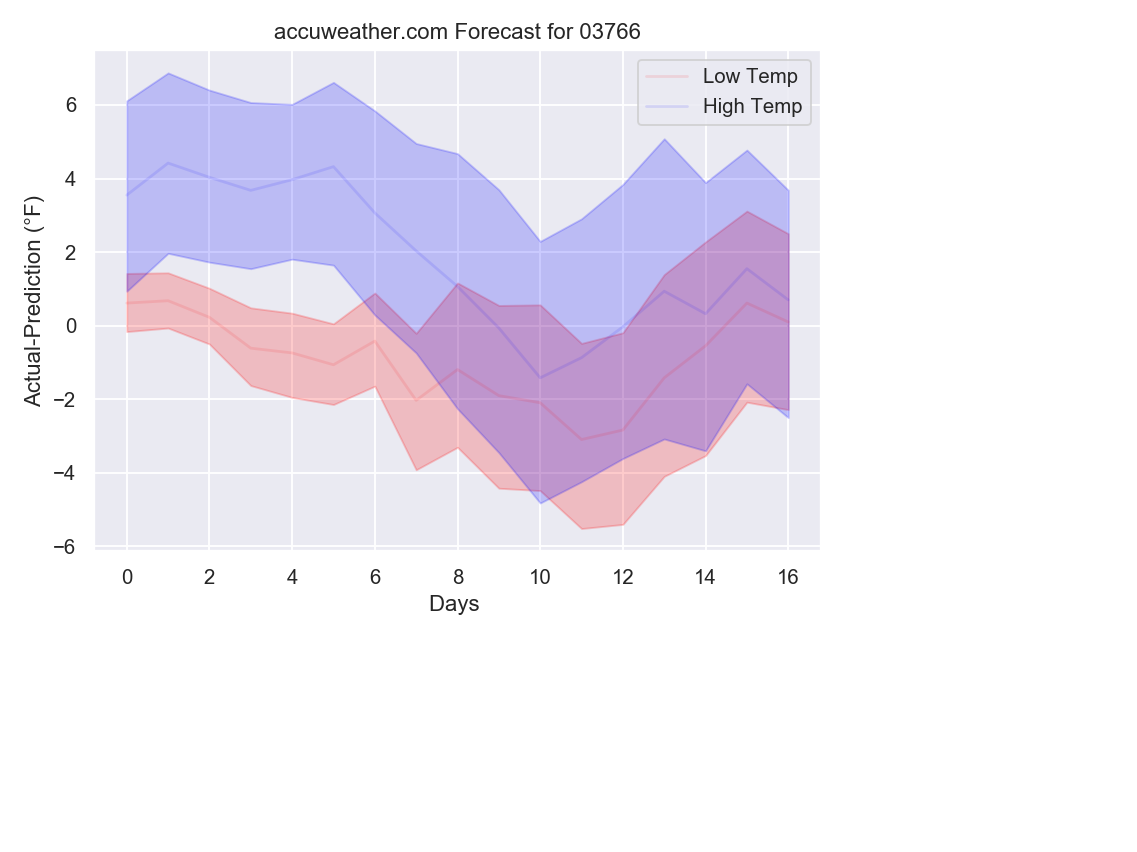

In [32]:
high_days_master = []
delta_highs_master = []
low_days_master = []
delta_lows_master = []

this_dict = awc_03766_dict

for d in this_dict.keys():
    for hL in this_dict[d].keys():
        act_high = this_dict[d]['high']['actual']
        act_low = this_dict[d]['low']['actual']
        
        day_delta_high_temp_list = [[i, h_t-act_high] for i, h_t in this_dict[d]['high']['pred'].items()]
        if day_delta_high_temp_list:
            days, delta_highs = zip(*day_delta_high_temp_list)
          
            high_days_master = high_days_master + list(days)
            delta_highs_master = delta_highs_master + list(delta_highs)
                 
        day_delta_low_temp_list = [[i, L_t - act_low] for i, L_t in this_dict[d]['low']['pred'].items()]
        if day_delta_low_temp_list:
            days, delta_lows = zip(*day_delta_low_temp_list)
        
            low_days_master = low_days_master + list(days)
            delta_lows_master = delta_lows_master + list(delta_lows)
            
plt.subplots()

s=-2 # has a couple extra entries at the end there are no forecasts for

sns.lineplot(x = high_days_master[:s], y = delta_highs_master[:s], color = 'red', alpha=.1, label = 'Low Temp')
    
sns.lineplot(x = low_days_master[:s], y = delta_lows_master[:s], color = 'blue', alpha=.1, label = 'High Temp')   

plt.title("accuweather.com Forecast for 03766")
plt.xlabel('Days ')
plt.ylabel('Actual-Prediction (°F)')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


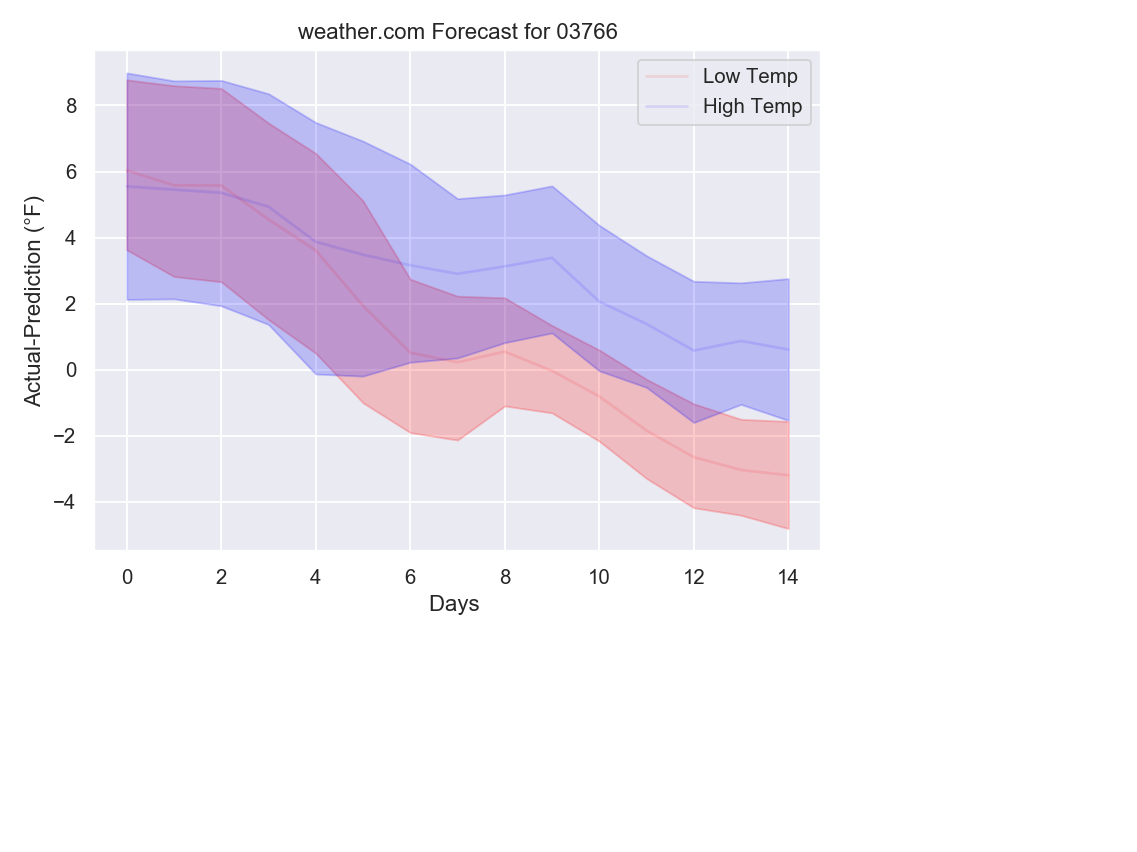

In [35]:
high_days_master = []
delta_highs_master = []
low_days_master = []
delta_lows_master = []

this_dict = wdc_03766_dict

for d in this_dict.keys():
    for hL in this_dict[d].keys():
        act_high = this_dict[d]['high']['actual']
        act_low = this_dict[d]['low']['actual']
        
        day_delta_high_temp_list = [[i, h_t-act_high] for i, h_t in this_dict[d]['high']['pred'].items()]
        if day_delta_high_temp_list:
            days, delta_highs = zip(*day_delta_high_temp_list)
          
            high_days_master = high_days_master + list(days)
            delta_highs_master = delta_highs_master + list(delta_highs)
                 
        day_delta_low_temp_list = [[i, L_t - act_low] for i, L_t in this_dict[d]['low']['pred'].items()]
        if day_delta_low_temp_list:
            days, delta_lows = zip(*day_delta_low_temp_list)
        
            low_days_master = low_days_master + list(days)
            delta_lows_master = delta_lows_master + list(delta_lows)
            
plt.subplots()

sns.lineplot(x = high_days_master, y = delta_highs_master, color = 'red', alpha=.1, label = 'Low Temp')
    
sns.lineplot(x = low_days_master, y = delta_lows_master, color = 'blue', alpha=.1, label = 'High Temp')   

plt.title("weather.com Forecast for 03766")
plt.xlabel('Days ')
plt.ylabel('Actual-Prediction (°F)')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


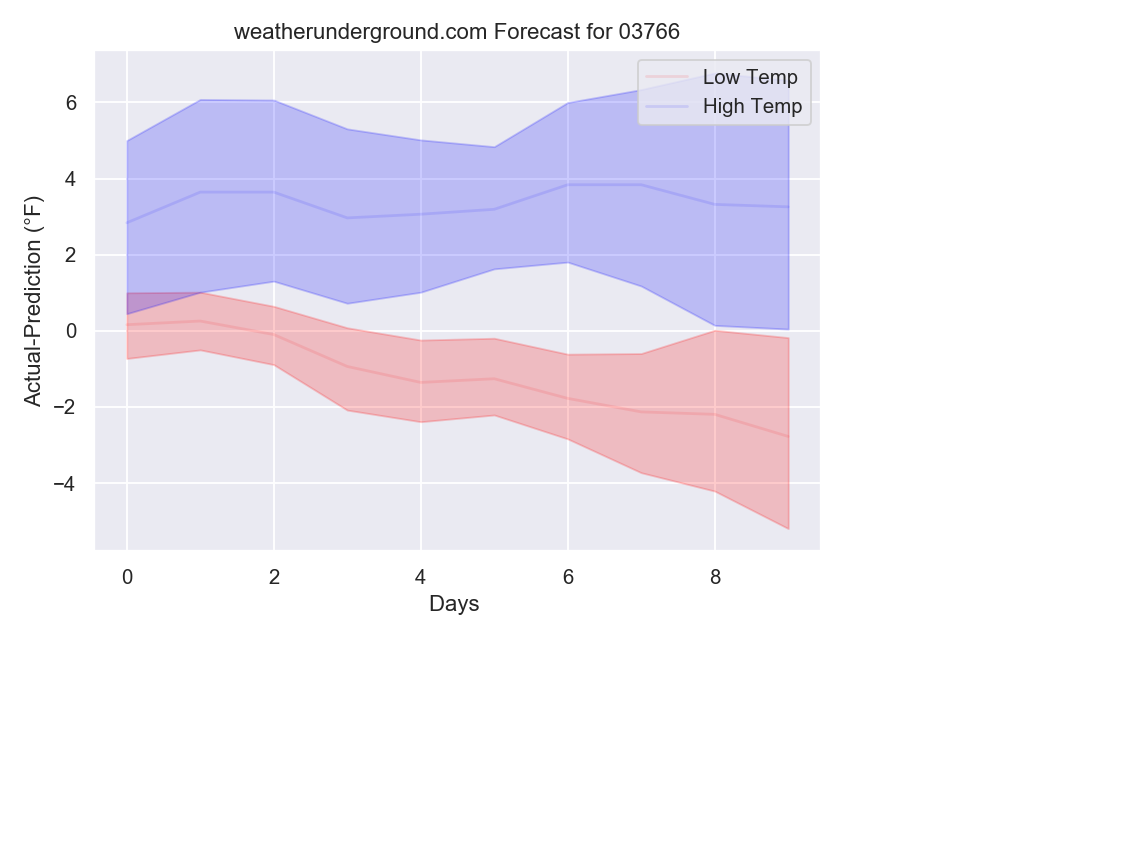

In [36]:
high_days_master = []
delta_highs_master = []
low_days_master = []
delta_lows_master = []

this_dict = wug_03766_dict

for d in this_dict.keys():
    for hL in this_dict[d].keys():
        act_high = this_dict[d]['high']['actual']
        act_low = this_dict[d]['low']['actual']
        
        day_delta_high_temp_list = [[i, h_t-act_high] for i, h_t in this_dict[d]['high']['pred'].items()]
        if day_delta_high_temp_list:
            days, delta_highs = zip(*day_delta_high_temp_list)
          
            high_days_master = high_days_master + list(days)
            delta_highs_master = delta_highs_master + list(delta_highs)
                 
        day_delta_low_temp_list = [[i, L_t - act_low] for i, L_t in this_dict[d]['low']['pred'].items()]
        if day_delta_low_temp_list:
            days, delta_lows = zip(*day_delta_low_temp_list)
        
            low_days_master = low_days_master + list(days)
            delta_lows_master = delta_lows_master + list(delta_lows)
            
plt.subplots()

sns.lineplot(x = high_days_master, y = delta_highs_master, color = 'red', alpha=.1, label = 'Low Temp')
    
sns.lineplot(x = low_days_master, y = delta_lows_master, color = 'blue', alpha=.1, label = 'High Temp')   

plt.title("weatherunderground.com Forecast for 03766")
plt.xlabel('Days ')
plt.ylabel('Actual-Prediction (°F)')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


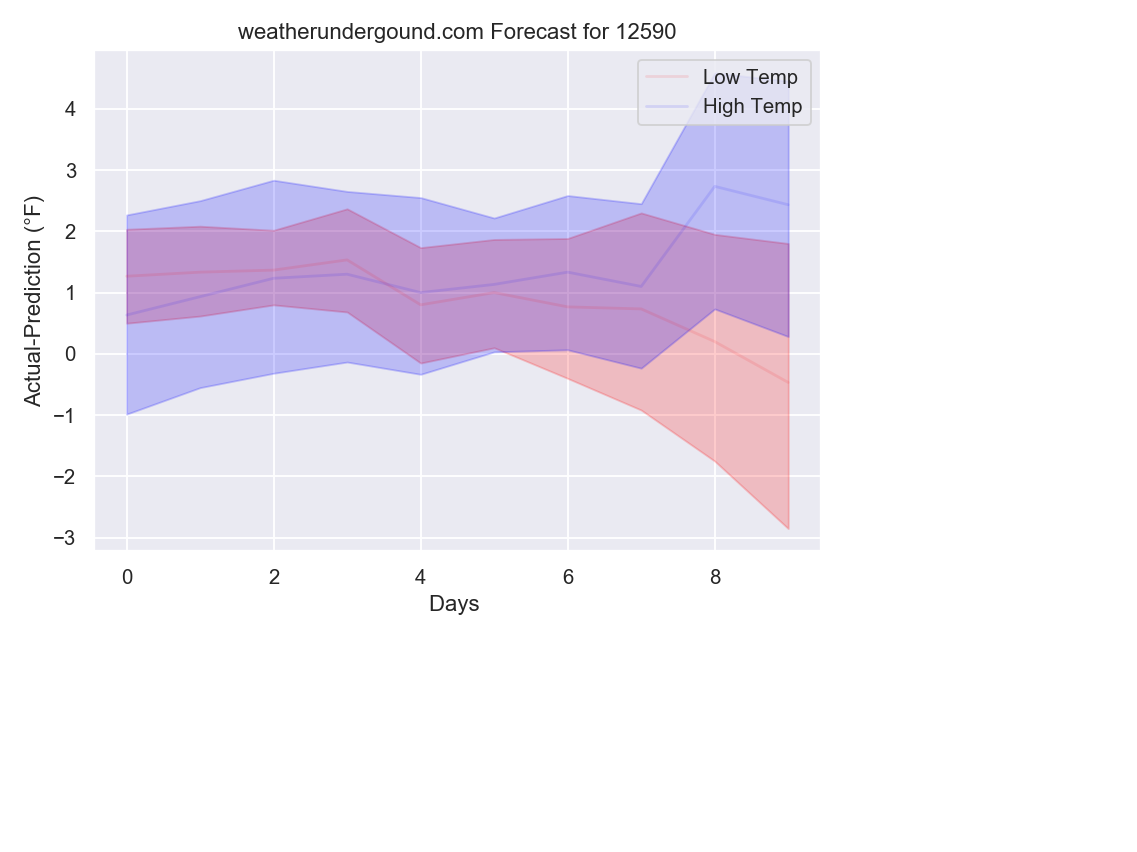

In [37]:
high_days_master = []
delta_highs_master = []
low_days_master = []
delta_lows_master = []

this_dict = wug_12590_dict

for d in this_dict.keys():
    for hL in this_dict[d].keys():
        act_high = this_dict[d]['high']['actual']
        act_low = this_dict[d]['low']['actual']
        
        day_delta_high_temp_list = [[i, h_t-act_high] for i, h_t in this_dict[d]['high']['pred'].items()]
        if day_delta_high_temp_list:
            days, delta_highs = zip(*day_delta_high_temp_list)
          
            high_days_master = high_days_master + list(days)
            delta_highs_master = delta_highs_master + list(delta_highs)
                 
        day_delta_low_temp_list = [[i, L_t - act_low] for i, L_t in this_dict[d]['low']['pred'].items()]
        if day_delta_low_temp_list:
            days, delta_lows = zip(*day_delta_low_temp_list)
        
            low_days_master = low_days_master + list(days)
            delta_lows_master = delta_lows_master + list(delta_lows)
            
plt.subplots()

sns.lineplot(x = high_days_master, y = delta_highs_master, color = 'red', alpha=.1, label = 'Low Temp')
    
sns.lineplot(x = low_days_master, y = delta_lows_master, color = 'blue', alpha=.1, label = 'High Temp')   

plt.title("weatherundergound.com Forecast for 12590")
plt.xlabel('Days ')
plt.ylabel('Actual-Prediction (°F)')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


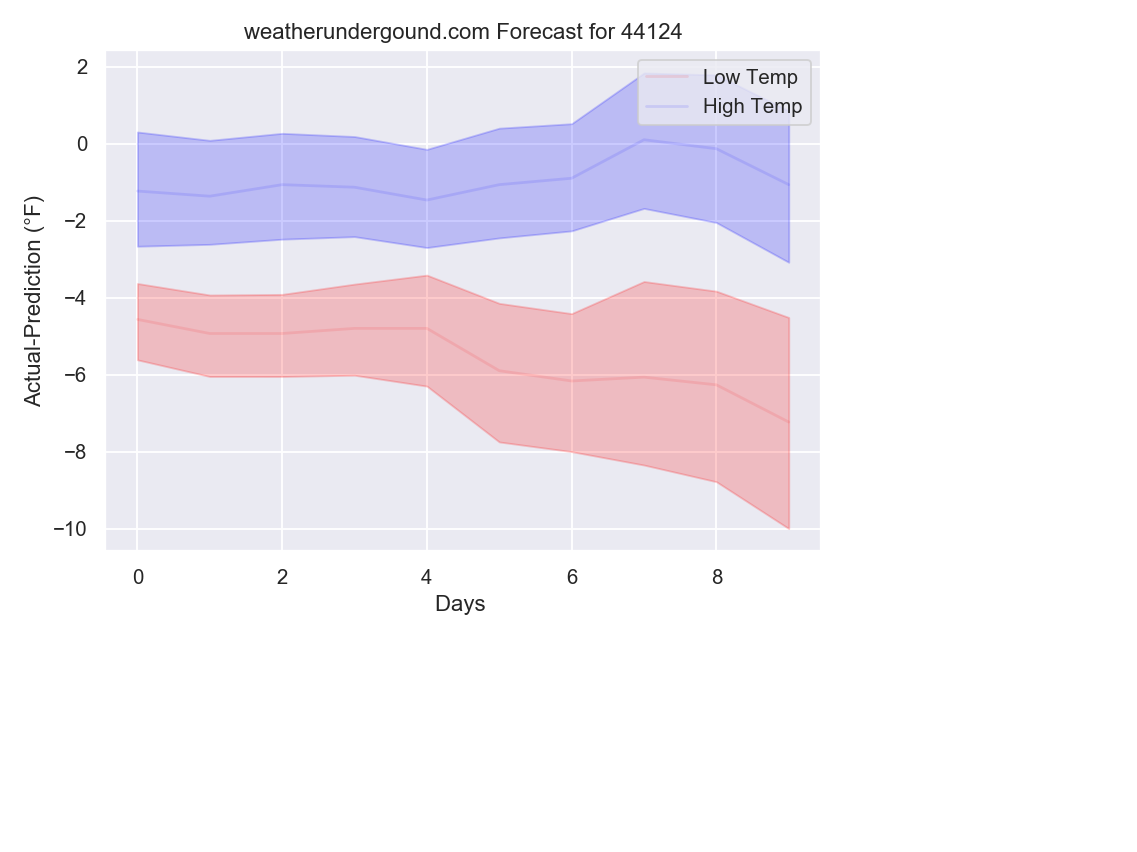

In [38]:
high_days_master = []
delta_highs_master = []
low_days_master = []
delta_lows_master = []

this_dict = wug_44124_dict

for d in this_dict.keys():
    for hL in this_dict[d].keys():
        act_high = this_dict[d]['high']['actual']
        act_low = this_dict[d]['low']['actual']
        
        day_delta_high_temp_list = [[i, h_t-act_high] for i, h_t in this_dict[d]['high']['pred'].items()]
        if day_delta_high_temp_list:
            days, delta_highs = zip(*day_delta_high_temp_list)
          
            high_days_master = high_days_master + list(days)
            delta_highs_master = delta_highs_master + list(delta_highs)
                 
        day_delta_low_temp_list = [[i, L_t - act_low] for i, L_t in this_dict[d]['low']['pred'].items()]
        if day_delta_low_temp_list:
            days, delta_lows = zip(*day_delta_low_temp_list)
        
            low_days_master = low_days_master + list(days)
            delta_lows_master = delta_lows_master + list(delta_lows)
            
plt.subplots()

sns.lineplot(x = high_days_master, y = delta_highs_master, color = 'red', alpha=.1, label = 'Low Temp')
    
sns.lineplot(x = low_days_master, y = delta_lows_master, color = 'blue', alpha=.1, label = 'High Temp')  

plt.title("weatherundergound.com Forecast for 44124")
plt.xlabel('Days ')
plt.ylabel('Actual-Prediction (°F)')
plt.legend()
plt.tight_layout()

## conclusions

Note that there are some really strange outliers in the historical data such as a high of 111 F in Wappingers Falls, NY on 1-27-2019 (see below). I checked the actually website and this is indeed there. Assuming that other the weird points, the historical data is correct, there are no real strong trends worth pointing out. This could be due to a couple of factors. First of all, I only scraped for the month of January 2019. Clearly the results would be better for some longer time periods. I do have concerns about scraping for more places and times since technically I doubt the websites approve of what I am doing as I am directly scraping from their sites. There is also a very subtle issue that some websites may not give historical weather for the exact same station that they show a daily prediction for, which could render some of this analysis moot. If I ever did any more scraping I would be EXTREMELY careful that the weather stations are the same. 

In [57]:
wug_historical_df_12590[57:58]

Temperature         Dew Point (° F)         Humidity (%)          \
0                 Max Avg Min             Max Avg Min          Max Avg Min   
date                                                                         
1-27-2019         111  64  17              30  24  16           93   -   6   

          Wind Speed (mph)         Pressure (Hg)            Precipation (in)  \
0                      Max Avg Min           Max Avg    Min              Max   
date                                                                           
1-27-2019               17   -   0         30.18   -  29.89                -   

                    
0          Avg Min  
date                
1-27-2019  0.0   -